# Ungraded Lab: Generating Text from Irish Lyrics

In the previous lab, you trained a model on just a single song. You might have found that the output text can quickly become gibberish or repetitive. Even if you tweak the parameters, the model will still be limited by its vocabulary of only a few hundred words. The model will be more flexible if you train it on a much larger corpus and that's what you'll be doing in this lab. You will use lyrics from more Irish songs then see how the generated text looks like. You will also see how this impacts the process from data preparation to model training. Let's get started!

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Building the Word Vocabulary

You will first download the lyrics dataset. These will be from a compilation of traditional Irish songs and you can see them [here](https://github.com/https-deeplearning-ai/tensorflow-1-public/blob/main/C3/W4/misc/Laurences_generated_poetry.txt).

In [ ]:
import os
try:
    import wget
except ModuleNotFoundError:
    print("Installing wget module...")
    !pip install wget
    import wget

def download_file(url, folder, filename):
    # Check if the folder exists, otherwise, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = os.path.join(folder, filename)

    # Check if the file has already been downloaded
    if not os.path.exists(file_path):
        print(f"Downloading file from {url}...")
        wget.download(url, out=folder)
        print("\nDownload completed.")
    else:
        print("The file has already been downloaded.")

# Specify the URL of the file, the destination folder, and the filename
url = "https://storage.googleapis.com/tensorflow-1-public/course3/irish-lyrics-eof.txt"
folder = "Vocabulary"
filename = "irish-lyrics-eof.txt"

# Call the function to download the file.
download_file(url, folder, filename)

Installing wget module...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1096a469ac46abea06076613c33b4776c3d0f86ccfed404e487ff55d3182f272
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Download completed.


Next, you will lowercase and split the plain text into a list of sentences:

In [ ]:
# Load the dataset
data = open('./Vocabulary/irish-lyrics-eof.txt').read()

# Lowercase and split the text
corpus = data.lower().split("\n")

# Preview the result
print(corpus)

['come all ye maidens young and fair', 'and you that are blooming in your prime', 'always beware and keep your garden fair', 'let no man steal away your thyme', 'for thyme it is a precious thing', 'and thyme brings all things to my mind', 'nlyme with all its flavours, along with all its joys', 'thyme, brings all things to my mind', 'once i and a bunch of thyme', 'i thought it never would decay', 'then came a lusty sailor', 'who chanced to pass my way', 'and stole my bunch of thyme away', 'the sailor gave to me a rose', 'a rose that never would decay', 'he gave it to me to keep me reminded', 'of when he stole my thyme away', 'sleep, my child, and peace attend thee', 'all through the night', 'guardian angels god will send thee', 'soft the drowsy hours are creeping', 'hill and dale in slumber sleeping', 'i my loving vigil keeping', 'while the moon her watch is keeping', 'while the weary world is sleeping', 'oer thy spirit gently stealing', 'visions of delight revealing', 'breathes a pure 

In [ ]:
import tensorflow as tf

# Initialize the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization()

# Build the vocabulary
vectorize_layer.adapt(corpus)

From here, you can initialize the `TextVectorization` class and generate the vocabulary:

In [ ]:
# Get the vocabulary and its size
vocabulary = vectorize_layer.get_vocabulary()
vocab_size = len(vocabulary)

print(f'The vocabulary is: {vocabulary}')
print(f'The vocabulary size is: {vocab_size}')

The vocabulary is: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('i'), np.str_('to'), np.str_('a'), np.str_('of'), np.str_('my'), np.str_('in'), np.str_('me'), np.str_('for'), np.str_('you'), np.str_('all'), np.str_('was'), np.str_('she'), np.str_('that'), np.str_('on'), np.str_('with'), np.str_('her'), np.str_('but'), np.str_('as'), np.str_('when'), np.str_('love'), np.str_('is'), np.str_('your'), np.str_('it'), np.str_('will'), np.str_('from'), np.str_('by'), np.str_('they'), np.str_('be'), np.str_('are'), np.str_('so'), np.str_('old'), np.str_('he'), np.str_('oh'), np.str_('no'), np.str_('ill'), np.str_('at'), np.str_('one'), np.str_('his'), np.str_('were'), np.str_('there'), np.str_('heart'), np.str_('down'), np.str_('where'), np.str_('we'), np.str_('now'), np.str_('young'), np.str_('never'), np.str_('go'), np.str_('then'), np.str_('not'), np.str_('did'), np.str_('come'), np.str_('said'), np.str_('away'), np.str_('them'), np.str_('their'), np.str_('sweet'), np.str_('green')

## Preprocessing the Dataset

Next, you will generate the inputs and labels for your model. The process will be identical to the previous lab. The `xs` or inputs to the model will be padded sequences, while the `ys` or labels are one-hot encoded arrays.

In [ ]:
import numpy as np

def preprocess_sequences(corpus, vectorize_layer, vocab_size):
    """
    Preprocesses text sequences for training data.

    Args:
        corpus (list): List of text sequences to be preprocessed.
        vectorize_layer : TextVectorization layer used for vectorizing text sequences.
        vocab_size (int): Size of the vocabulary for one-hot encoding.

    Returns:
        tuple: A tuple containing preprocessed input sequences, labels, complete preprocessed input sequences,
        one-hot encoded labels, and the maximum sequence length
    """
    # Initialize the sequences list
    input_sequences = []

    # Loop over every line
    for line in corpus:
        # Generate the integer sequence of the current line
        sequence = vectorize_layer(line).numpy()

        # Loop over the line several times to generate the subphrases
        for i in range(1, len(sequence)):

            # Generate the subphrase
            n_gram_sequence = sequence[:i+1]

            # Append the subphrase to the sequences list
            input_sequences.append(n_gram_sequence)

    # Get the length of the longest line
    max_sequence_len = max([len(x) for x in input_sequences])

    # Pad all sequences
    input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    # Create inputs and label by splitting the last token in the subphrases
    xs, labels = input_sequences[:, :-1], input_sequences[:, -1]

    # Convert the label into one-hot arrays
    ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

    return xs, labels, input_sequences, ys, max_sequence_len

# Utiliza la función preprocess_sequences con los parámetros adecuados
xs, labels, input_sequences, ys, max_sequence_len = preprocess_sequences(corpus, vectorize_layer, vocab_size)

You can then print some of the examples as a sanity check.

In [ ]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence:
  token_list.append(vocabulary.index(word))

# Print the token list
print(token_list)

sample sentence: ['come', 'all', 'ye', 'maidens', 'young', 'and', 'fair']
[55, 13, 96, 1886, 49, 3, 71]


In [ ]:
def sequence_to_text(sequence, vocabulary):
  '''
    Utility function to convert an integer sequence back to text.

    Args:
        sequence (list): Integer sequence to be converted back to text.
        vocabulary (list or dict): Vocabulary mapping integers to corresponding words.

    Returns:
        str: The text representation of the input integer sequence.
  '''

  # Loop through the integer sequence and look up the word from the vocabulary
  words = [vocabulary[index] for index in sequence]

  # Combine the words into one sentence
  text = tf.strings.reduce_join(words, separator=' ').numpy().decode()

  return text

In [ ]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [   0    0    0    0    0    0    0    0    0   55   13   96 1886   49
    3]
decoded to text:          come all ye maidens young and
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 71


Lastly, since this is a larger dataset, you can use the tf.data API to speed up the training.

In [ ]:
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Put the inputs and labels to a tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((xs,ys))

# Optimize the dataset for training
dataset = dataset.cache().prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)

## Build and compile the Model

Next, you will build and compile the model. We placed some of the hyperparameters at the top of the code cell so you can easily tweak it later if you want.

In [ ]:
# Parameters
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# Build the model
model = tf.keras.models.Sequential([
            tf.keras.Input(shape=(max_sequence_len-1,)),
            tf.keras.layers.Embedding(vocab_size, embedding_dim),
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
            tf.keras.layers.Dense(vocab_size, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
    )

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 15, 100)             │         270,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2704)                │         813,904 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,385,504 (5.29 MB)

 Trainable params: 1,385,504 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

From the model summary above, you'll notice that the number of trainable params is much larger than the one in the previous lab. Consequently, that usually means a slower training time. It will take roughly 7 seconds per epoch with the GPU enabled in Colab and you'll reach around 76% accuracy after 100 epochs.

In [ ]:
epochs = 100

# Train the model
history = model.fit(dataset, epochs=epochs)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0608 - loss: 6.8954
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0781 - loss: 6.0136
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0946 - loss: 6.4283
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1137 - loss: 6.0473
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1407 - loss: 5.3343
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1597 - loss: 5.2499
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.1867 - loss: 4.6049
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2455 - loss: 4.0729
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2935 - loss: 3.5374
Epoch 10/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3549 - loss: 3.0452
Epoch 11/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4186 - loss: 2.6082
Epoch 12/100
375/375 ━━━━━━━━━━━━━━━━━━━━

You can visualize the accuracy below to see how it fluctuates as the training progresses.

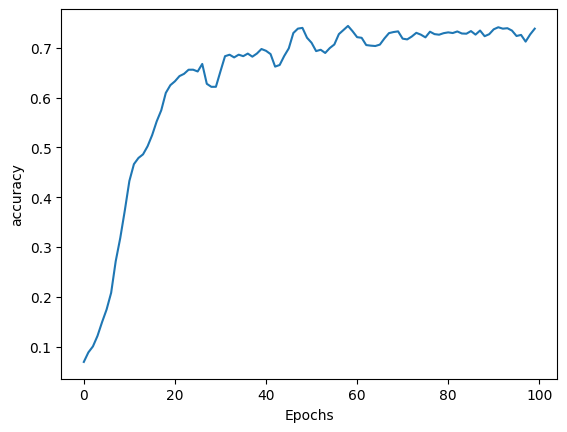

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

Now you can let the model make its own songs or poetry! Because it is trained on a much larger corpus, the results below should contain less repetitions as before. The code below picks the next word based on the highest probability output.

In [ ]:
# Define seed text
seed_text = "help me obi-wan kenobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(seed_text)

	# Pad the sequence
	sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(sequence, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = vocabulary[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kenobi youre my only hope home to while not did say theres beaming gone away at spancil corporal casey grandmother night unseen renown cry my days gone in rosy runaway for mallow auld rigadoo gay for your wife sinking your barley and tears hands free with my friends for mallow roaming free wid your barley away again by fly on onaisy ones and love be got your rest teacher so beguiled gone by fight street and gone through derry on wid side gone away in the sea love each years gone alas for gone in strife assembled thee i fly them fervor hill today and


Here again is the code that gets the top 3 predictions and picks one at random.

In [ ]:
# Define seed text
seed_text = "help me obi-wan kenobi youre my only hope"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to an integer sequence
  sequence = vectorize_layer(seed_text)

	# Pad the sequence
  sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(sequence, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

    # Look up the word associated with the index.
    output_word = vocabulary[predicted]

    # Combine with the seed text
    seed_text += " " + output_word

# Print the result
print(seed_text)

help me obi-wan kenobi youre my only hope to raindrops seen back when he died for in wid the gone for sayin laughter your phelim thee more friends before fountain gone as the high tree country love mary mccann out wexford away oer the fire that our gone land awake sport and tea rostrevor innocent catchers color them gone in ballyjamesduff odd and gay love my love gone in rosy ones coaxin onaisy of erins squall tree high tree dew friends for oer stars malone moon shine far wid glen again since killarney corporal corporal wid save away cross the sea of youths barney ray roving beaming crying


## Wrap Up

This lab shows the effect of having a larger dataset to train your text generation model. As expected, this will take a longer time to prepare and train but the output will less likely become repetitive or gibberish. Try to tweak the hyperparameters and see if you get better results. You can also find some other text datasets and use it to train the model here.  

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}